# Final Project Submission

Please fill out:
* Student name: Deztany Jackson
* Student pace: DS Flex
* Scheduled project review date/time: March 23, 2023
* Instructor name: Morgan Jones
* Blog post URL: Dmvinedata.com

In [ ]:
"""References for Use:
    Transfer Learning: https://www.youtube.com/watch?v=fj9Y6T7mOyE <br>
    
"""

# Summary- 250 Words
    Business Problem
    Data Understanding
    Data Preparation
    Modeling
    Evaluation
    Conclusion

# Data Understanding


Write a few sentences on the approach to Data Understanding

In [142]:
import os # Getting data 
import glob #Google Collab
#from google.colab import drive #Google Collab

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.metrics import AUC, Accuracy,Precision,Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
#from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, VGG19 #Pretrained Transfer Modeling
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight #Unsure what this is for
#from sklearn.metrics import plot_precision_recall_curve 
import datetime

import pathlib
import shutil

import warnings
warnings.filterwarnings('ignore')
tf.__version__
#plot_confusion matrix

# Showing the areas of the image
#import lime
#from lime import lime_base
#from lime import lime_image
#from skimage.segmentation import mark_boundaries

'2.9.2'

In [ ]:
conda install 

In [2]:
#Time
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [4]:
#Load data
#Count each category
cur_dir = os.getcwd()
cur_dir


'/Users/deztanyjackson/Documents/0_Flatiron/Phase_4/Project_4/Image_Classification_P4'

In [5]:
#Puling data in...already know the categories from the problem
train_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/**/*.jpeg'))
val_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/**/*.jpeg'))
test_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/test/**/*.jpeg'))

print("〰"*20)
print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")
print("〰"*20)

〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Training Set has: 4352 images
Testing Set has: 624 images
Validation Set has: 880 images
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰


In [6]:
DIR = "../chest_xray/"
sets = ["train", "val", "test"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)
print("〰"*20)
print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")
print(f"Ratio of Normal: {round(len(all_normal)/len(all_pneumonia),2)}")
print("〰"*20)

〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Total Pneumonia Images: 4273
Total Normal Images: 1583
Ratio of Normal: 0.37
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰


In [7]:
v_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/PNEUMONIA/*.jpeg'))
v_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/NORMAL/*.jpeg'))
t_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/NORMAL/*.jpeg'))
t_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/PNEUMONIA/*.jpeg'))
test_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/NORMAL/*.jpeg'))
test_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/PNEUMONIA/*.jpeg'))

In [8]:
#Moving Validation to Test


cat = [v_norm,v_pneu]

for c in cat:
    if c == v_norm:
        images = [f for f in v_norm if '.jpeg' in f.lower()] 
        for img in images:
            new_path = os.path.join(cur_dir,"data/chest_xray/train/NORMAL/")
            shutil.move(img,new_path)
    elif c == v_pneu:
        images = [f for f in v_pneu if '.jpeg' in f.lower()] 
        for img in images:
            new_path = os.path.join(cur_dir,"data/chest_xray/train/PNEUMONIA/")
            shutil.move(img,new_path)
    else:
        pass


In [9]:
train_cat = [t_norm,t_pneu]

for cat in train_cat:
    train,val = train_test_split(cat, train_size=.8, random_state=42)
    if cat == t_norm:
        for img in val:
            new_path = os.path.join(cur_dir,"data/chest_xray/val/NORMAL/")
            shutil.move(img,new_path)
    elif cat == t_pneu:
        for img in val:
            new_path = os.path.join(cur_dir,"data/chest_xray/val/PNEUMONIA/")
            shutil.move(img,new_path)
    else:
        pass
    

In [10]:
v_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/PNEUMONIA/*.jpeg'))
v_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/NORMAL/*.jpeg'))
t_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/NORMAL/*.jpeg'))
t_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/PNEUMONIA/*.jpeg'))
test_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/NORMAL/*.jpeg'))
test_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/PNEUMONIA/*.jpeg'))

In [11]:
print("〰"*20)
print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")
print("〰"*20)

〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Training Set has: 4352 images
Testing Set has: 624 images
Validation Set has: 880 images
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰


In [12]:
print(f"Validation Pneumonia Amount: {len(v_pneu)} images")
print(f"Validation Normal Amount: {len(v_norm)} images")
print(f"Validation Normal to Pneumonia Ratio: {round(len(v_norm)/len(v_pneu),2)}")


Validation Pneumonia Amount: 646 images
Validation Normal Amount: 225 images
Validation Normal to Pneumonia Ratio: 0.35


There is still imbalance but better offset

In [13]:
# Graph of Pneumonia to Normal count (All, Train, Val, Test)
#Visualize samples from Normal and Pneumonia

Sample of Random Normal Pictures


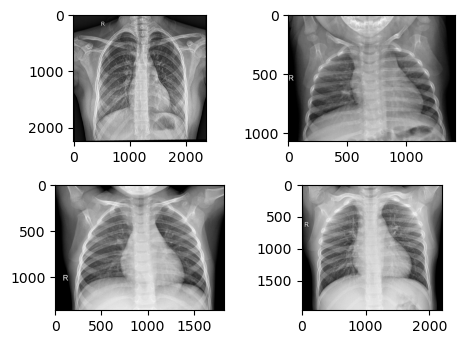

In [14]:
plt.figure(figsize = (5,5))
print ("Sample of Random Normal Pictures")
for i in range(4):
    plt.subplot(3,2,i+1)
    img = plt.imread(t_norm[i])
    plt.imshow(img, cmap = "gray")
    plt.tight_layout()
    #plt.axis('off')

Sample of Random Pneumonia Pictures


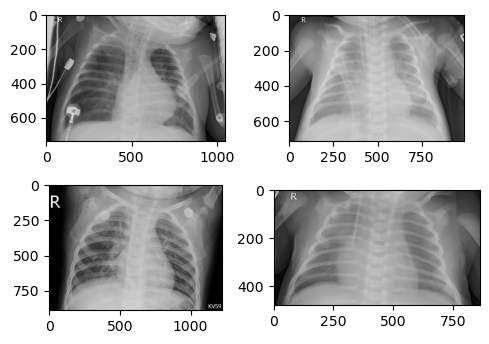

In [15]:
plt.figure(figsize = (5,5))
print ("Sample of Random Pneumonia Pictures")
for i in range(4):
    plt.subplot(3,2,i+1)
    img = plt.imread(t_pneu[i])
    plt.imshow(img, cmap = "gray")
    plt.tight_layout()
    #plt.axis('off')

Visually, both the Normal and Pneumonia pictures vary in size. Pneumonia pictures have a cloudier look.

#Reschaling the image [Rescaling](https://datascience.stackexchange.com/questions/92499/rescale-parameter-in-data-augmentation#:~:text=As%20rightly%20pointed%20out%20by,evenly%20to%20the%20total%20loss)

In [16]:
#ImageDataGenerator without data augmentation

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
#Directories
train_directory= 'data/chest_xray/train'
validation_directory= 'data/chest_xray/val'
test_directory = 'data/chest_xray/test'


In [80]:
#Using a generator for the images to work with.
train_gen = train_datagen.flow_from_directory(train_directory,
                                                   target_size = (224, 224),
                                                   batch_size=50,
                                                   classes = ["NORMAL","PNEUMONIA"],
                                                   class_mode = 'binary',
                                                   
                                                   seed = 42)

val_gen = val_datagen.flow_from_directory(validation_directory,
                                                      target_size = (224, 224),
                                                      batch_size = 50,
                                                      classes = ["NORMAL","PNEUMONIA"],
                                                      class_mode = 'binary',
                                                      seed = 42)
test_gen = test_datagen.flow_from_directory(test_directory,
                                                      target_size = (224, 224),
                                                      batch_size = 624,
                                                      classes = ["NORMAL","PNEUMONIA"],
                                                      class_mode = 'binary',
                                                      seed = 42,
                                                      shuffle= False)                                                      

Found 4361 images belonging to 2 classes.
Found 871 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [19]:
#Checking the class label and index match
print(train_gen.class_indices)
print(val_gen.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


[4273, 1583]


<Axes: ylabel='count'>

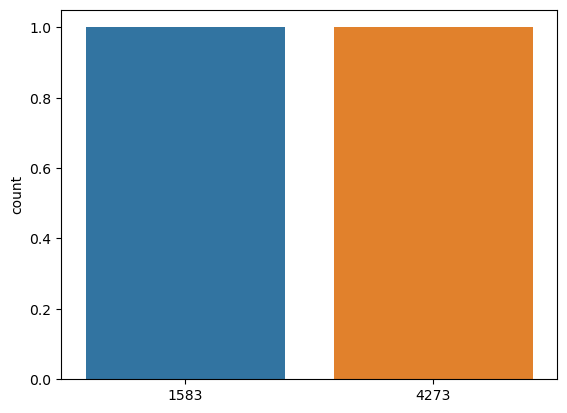

In [21]:
"""# Plot the count fo the Pneumonia for All and Training using the X and y

labels = [ "Pneumonia", "Normal"]
values = [len(all_pneumonia), len(all_normal) ]
colors = ["orange", "blue"]
print(values)
sns.countplot(x = values, label = labels)

#Distribution of Category Variables
fig,ax=plt.subplots(figsize=(8,8), facecolor = "white")
sns.countplot(x = "Category", data=paris_df)
plt.title('Distribution of Categories on Data')
plt.grid(axis = "y")
plt.show()
fig.savefig("images/dist.png", dpi=150)"""

In [22]:
#Import data
#Count Images, Count Class
#Plot distribution of count
#Plot pictures of Pnuemonia and Normal x2
#Plot distribution of count
#Check shape
#Why does data need to be normalized? Describe why 

In [81]:
X_train, y_train = next(train_gen)
X_test, y_test = next(test_gen)
X_val, y_val = next(val_gen)

# Baseline Modeling

In [23]:
baseline = models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
       padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 
    
Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
    
Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
Flatten(),
Dense(units=64, activation='sigmoid'),    
Dense(units=1, activation='sigmoid'),
])

Metal device set to: Apple M2 Max


2023-03-21 00:04:22.387304: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-21 00:04:22.387436: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
baseline.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=["acc","Recall","Precision"])

In [25]:
baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 96)       0

In [83]:
history = baseline.fit(train_gen,
                       epochs=10,
                       verbose = 2,
                       validation_data=val_gen)

Epoch 1/10
88/88 - 19s - loss: 0.5709 - acc: 0.7423 - recall: 1.0000 - precision: 0.7423 - val_loss: 0.5714 - val_acc: 0.7417 - val_recall: 1.0000 - val_precision: 0.7417 - 19s/epoch - 214ms/step
Epoch 2/10
88/88 - 19s - loss: 0.5708 - acc: 0.7423 - recall: 1.0000 - precision: 0.7423 - val_loss: 0.5713 - val_acc: 0.7417 - val_recall: 1.0000 - val_precision: 0.7417 - 19s/epoch - 220ms/step
Epoch 3/10
88/88 - 19s - loss: 0.5708 - acc: 0.7423 - recall: 1.0000 - precision: 0.7423 - val_loss: 0.5713 - val_acc: 0.7417 - val_recall: 1.0000 - val_precision: 0.7417 - 19s/epoch - 218ms/step
Epoch 4/10
88/88 - 19s - loss: 0.5708 - acc: 0.7423 - recall: 1.0000 - precision: 0.7423 - val_loss: 0.5713 - val_acc: 0.7417 - val_recall: 1.0000 - val_precision: 0.7417 - 19s/epoch - 215ms/step
Epoch 5/10
88/88 - 19s - loss: 0.5708 - acc: 0.7423 - recall: 1.0000 - precision: 0.7423 - val_loss: 0.5714 - val_acc: 0.7417 - val_recall: 1.0000 - val_precision: 0.7417 - 19s/epoch - 217ms/step
Epoch 6/10
88/88 - 1

In [27]:
#Build functions to output
#- Confusion Matrix (normalized)
# Classification Report
#ROC AUC Report

[Visualization Metrics,A.Jang 2023](https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays#8.-Visualizing-model-performance)

In [145]:
def eval_metrics(history):
    """ Enter Docstring information Plotting the accuracy and the loss of the training and validation model"""
    
    fig, ax = plt.subplots(1,4, figsize = (25,5))
    fig.suptitle('Model Metrics Results')
    
    metrics = ["acc","loss","recall","precision"]   
    
    for i, metric in enumerate(metrics):
    
        ax[i].plot(history.history["train_"+ metric])
        ax[i].plot(history.history["val_" + metric])
        ax[i].set_title('Model {}'.format(metric))
        ax[i].set_ylabel(metric)
        ax[i].set_xlabel("Epochs")
        ax[i].legend(['train', 'val'])

        

[Predictor Algorithm with Shuffle,by Jakob, 2021](https://stackoverflow.com/questions/45413712/keras-get-true-labels-y-test-from-imagedatagenerator-or-predict-generator/67282636#67282636)

In [89]:
def predict_results(model, generator):
    """Generator with shuffle = True"""
    
    # Create lists for storing the predictions and labels
    predictions = []
    labels = []

    # Get the total number of labels in generator 
    # (i.e. the length of the dataset where the generator generates batches from)
    n = len(generator.labels)

    # Loop over the generator
    for data, label in generator:
        # Make predictions on data using the model. Store the results.
        predictions.extend(model.predict(data).flatten())

        # Store corresponding labels
        labels.extend(label)

        # We have to break out from the generator when we've processed 
        # the entire once (otherwise we would end up with duplicates). 
        if (len(label) < generator.batch_size) and (len(predictions) == n):
            break
        return labels, predictions #y_true, y_hat_train/y_pred

In [118]:
labels, predictions = predict_results(baseline,test_gen)

20/20 [==============================] - 1s 46ms/step


In [126]:
def conf_matrix(y_true,y_pred, norm_bool):
    
    y_pred = np.round(y_pred,0) #Rounding to the nearest 0 or 1, assumes threshold is >.5 for
    cmatrix= cm(y_true, y_pred, normalize=norm_bool)
    matrix_disp= ConfusionMatrixDisplay(cmatrix, display_labels= ["NORMAL", "PNUEMONIA"])
    matrix_disp.plot()

    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.title('Model Confusion Matrix')
    plt.show()
    

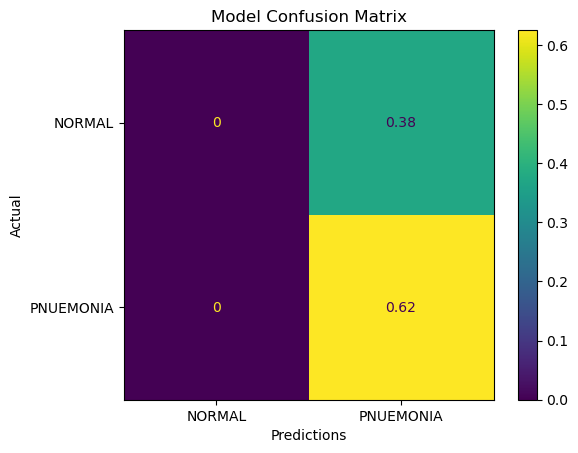

In [127]:
conf_matrix(labels,predictions, "all")

In [44]:
# def plot_roc_auc():
# def plot_roc_auc():

def data_disp(datatype_string):
    print(f'Reporting.{}Info" {datatype_string})

In [143]:
def eval_report(y_true, y_pred,gen):
    
    y_pred = np.round(y_pred,0) # Rounding to the nearest 0 or 1
    #Display Precision, Recall, F1 and Accuracy
    print(classification_report(y_true, y_pred))
    print('\n')
    
    #Display Model Metrica
    loss, acc, recall, precision = history.model.evaluate(gen)
    print(f'Test Loss: {loss}')
    

In [144]:
eval_report(labels,predictions,test_gen)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       234
         1.0       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



1/1 [==============================] - 2s 2s/step - loss: 0.6975 - acc: 0.6250 - recall: 1.0000 - precision: 0.6250
Test Loss: 0.6974759101867676


In [ ]:
#Clean up Reporting
#Class Weights
#Iterations